## Import libraries & data

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

In [1]:
!pip install textstat

     -------------------------------------- 105.1/105.1 kB 1.0 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 1.9 MB/s eta 0:00:00


In [15]:
!pip install google-colab

     -------------------------------------- 425.3/425.3 kB 1.6 MB/s eta 0:00:00
     -------------------------------------- 385.8/385.8 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: tornado
    Found existing installation: tornado 4.5.3
    Uninstalling tornado-4.5.3:
      Successfully uninstalled tornado-4.5.3
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.2 which is incompatible.


In [18]:
!pip install textblob

     ------------------------------------ 636.8/636.8 kB 743.2 kB/s eta 0:00:00


In [19]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import missingno as msno
#from google.colab import data_table
from tabulate import tabulate
import scipy.stats as st
import matplotlib as mpl
import matplotlib.patches as mpl_patches
import matplotlib.cm as cm
import matplotlib.lines as mlines
import re
import nltk
import spacy
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer  
from textblob import TextBlob
from textstat import flesch_reading_ease
tqdm.pandas()
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [20]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')  
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\youse\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\youse\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\youse\AppData\Roaming\nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\youse\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\youse\AppData\Roaming\nltk_data...


True

In [25]:
final_df = pd.read_csv('final_df_preprocessed_2021111201.csv')

In [26]:
final_df.sample(5)

,correct,incorrect,correct_char_count,incorrect_char_count,correct_word_count,incorrect_word_count
475510,I am not sure how or what I should do for the ...,I am not sure how or what I should do the next...,57,53,15,14
160073,So I want to practice drawing more and more .,And I want to draw practical .,45,30,10,7
435029,"Three hours later , I left Starbucks and I cam...","Three hours later , I left from Starbucks and ...",54,59,12,13
32062,Today is July th on the Chinese lunar calendar,According to Chinese Traditional Lunar Calenda...,47,69,9,12
480952,and I drank lots of alcohol .,and I drunk many alcohole .,29,27,7,6


In [27]:
final_df.shape

(496287, 6)

### Adding length features

In [28]:
final_df['correct_char_count'] = final_df['correct'].astype('str').apply(lambda x:len(x))
final_df['incorrect_char_count'] = final_df['incorrect'].astype('str').apply(lambda x:len(x))

In [29]:
final_df['correct_word_count'] = final_df['correct'].astype('str').apply(lambda x:len(x.split()))
final_df['incorrect_word_count'] = final_df['incorrect'].astype('str').apply(lambda x:len(x.split()))

In [30]:
final_df.sample(5)

,correct,incorrect,correct_char_count,incorrect_char_count,correct_word_count,incorrect_word_count
3040,But you should know there are people who do n...,But you should know there are people who do n...,67,69,15,16
408100,It is very cheap .,It is very cheep .,19,19,5,5
339171,"We like `` The very hungry caterpillar `` , wr...","We like `` The very hungry caterpillar `` , wr...",67,66,14,14
127150,"As I was writing this journal , the taro dish ...","As I was writing this journal , the taro dish ...",124,113,28,24
374985,I hope I can get over it unless I can have som...,I wish I can get over it unless I can have som...,84,87,19,19


## Univariate Analysis(KDE Plots)

In [31]:
def plot_univariate(df,feature_name):
    '''Plots KDE plot of specified feature name from dataframe'''
    random_color = (random.random(), random.random(), random.random())
    df.plot(kind='kde',y=feature_name,figsize=(25,5),grid=True,color=random_color)
    plt.title(f'KDE-{feature_name.replace("_"," ")}')
    plt.show()

In [32]:
def show_percentiles(df,feature_name,quantile_range,quantile_incr):
    '''shows quantiles  of specified feature name from dataframe in specified range'''
    quantiles = np.arange(quantile_range[0],quantile_range[1],quantile_incr)
    quant_array = [np.percentile(df[feature_name] , i) for i in quantiles]
    return pd.DataFrame(quant_array,columns=[feature_name]).set_index(quantiles).transpose()

### Character Count

#### Correct Sentences


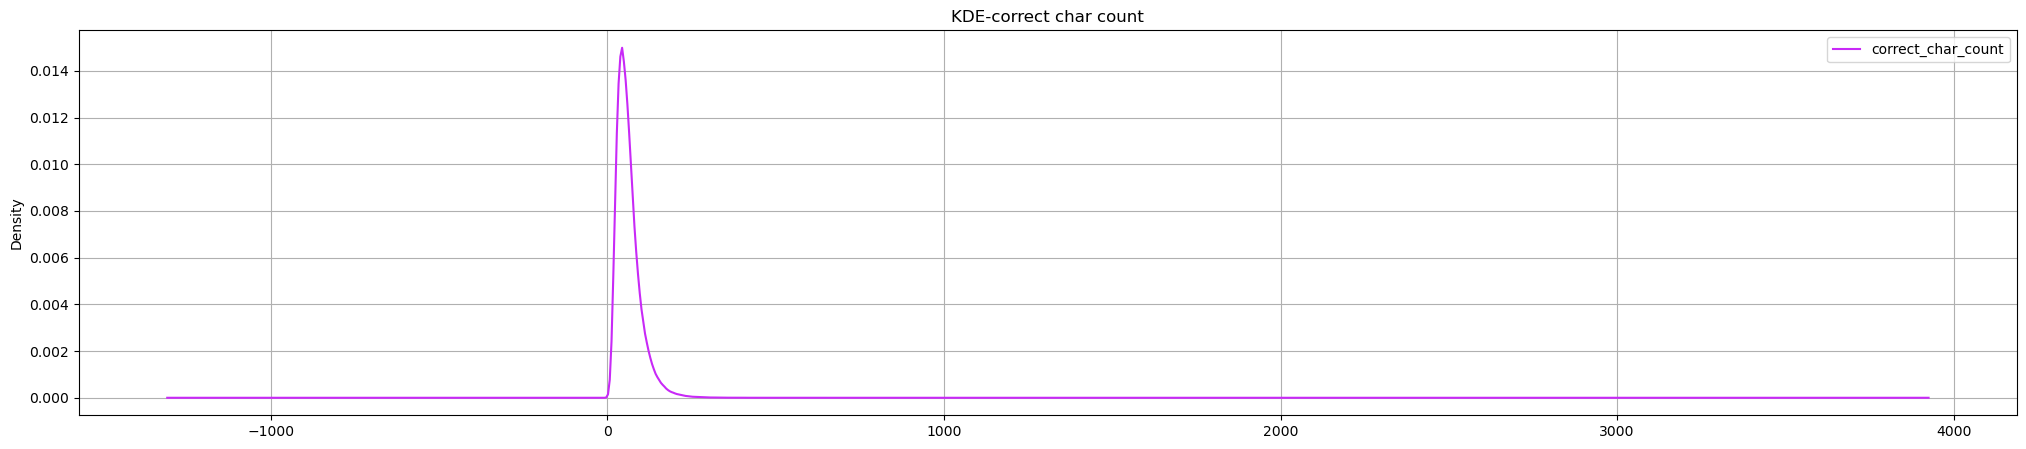

In [33]:
plot_univariate(final_df,'correct_char_count')

In [34]:
final_df['correct_char_count'].describe()

count    496287.000000
mean         63.573319
std          36.887330
min           1.000000
25%          39.000000
50%          56.000000
75%          79.000000
max        2617.000000
Name: correct_char_count, dtype: float64

In [35]:
show_percentiles(final_df,'correct_char_count',(0,101),5)

,0,5,10,15,20,25,30,35,40,45,...,55,60,65,70,75,80,85,90,95,100
correct_char_count,1.0,22.0,27.0,31.0,35.0,39.0,42.0,45.0,49.0,52.0,...,60.0,64.0,68.0,73.0,79.0,86.0,96.0,109.0,132.0,2617.0


In [36]:
show_percentiles(final_df,'correct_char_count',(90,101),1)

,90,91,92,93,94,95,96,97,98,99,100
correct_char_count,109.0,113.0,117.0,121.0,126.0,132.0,140.0,150.0,164.0,189.0,2617.0


In [37]:
show_percentiles(final_df,'correct_char_count',(99.1,100),0.1)

,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100.0
correct_char_count,194.0,198.0,203.0,209.0,216.0,225.0,238.0,257.0,289.714,2617.0


In [38]:
show_percentiles(final_df,'correct_char_count',(99.9,100),0.01)

,99.90,99.91,99.92,99.93,99.94,99.95,99.96,99.97,99.98,99.99
correct_char_count,289.714,295.0,302.0,310.0,317.0,329.0,341.0,363.0,393.4856,446.0


#### Incorrect Sentences

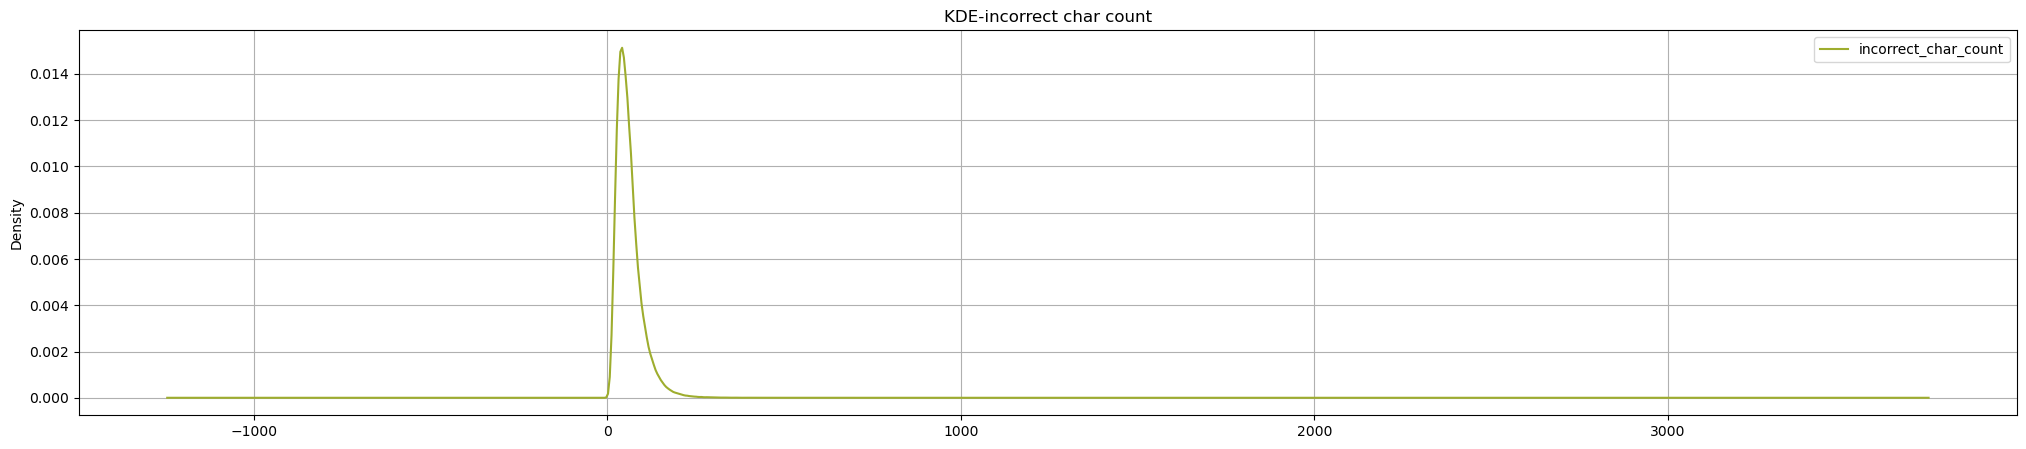

In [39]:
plot_univariate(final_df,'incorrect_char_count')

In [40]:
final_df['incorrect_char_count'].describe()

count    496287.000000
mean         61.711008
std          36.527865
min           1.000000
25%          37.000000
50%          54.000000
75%          77.000000
max        2492.000000
Name: incorrect_char_count, dtype: float64

In [41]:
show_percentiles(final_df,'incorrect_char_count',(0,101),5)

,0,5,10,15,20,25,30,35,40,45,...,55,60,65,70,75,80,85,90,95,100
incorrect_char_count,1.0,20.0,26.0,30.0,34.0,37.0,40.0,44.0,47.0,50.0,...,58.0,62.0,66.0,71.0,77.0,84.0,93.0,107.0,130.0,2492.0


In [42]:
show_percentiles(final_df,'incorrect_char_count',(90,101),1)

,90,91,92,93,94,95,96,97,98,99,100
incorrect_char_count,107.0,110.0,114.0,119.0,124.0,130.0,137.0,147.0,161.0,187.0,2492.0


In [43]:
show_percentiles(final_df,'incorrect_char_count',(99.1,100),0.1)

,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100.0
incorrect_char_count,191.0,196.0,201.0,206.0,213.0,223.0,235.0,253.0,287.0,2492.0


In [44]:
show_percentiles(final_df,'incorrect_char_count',(99.9,100),0.01)

,99.90,99.91,99.92,99.93,99.94,99.95,99.96,99.97,99.98,99.99
incorrect_char_count,287.0,293.0,300.0,307.5998,315.0,326.857,338.4856,360.0,389.7428,441.7428


### Word Count

#### Correct Sentences

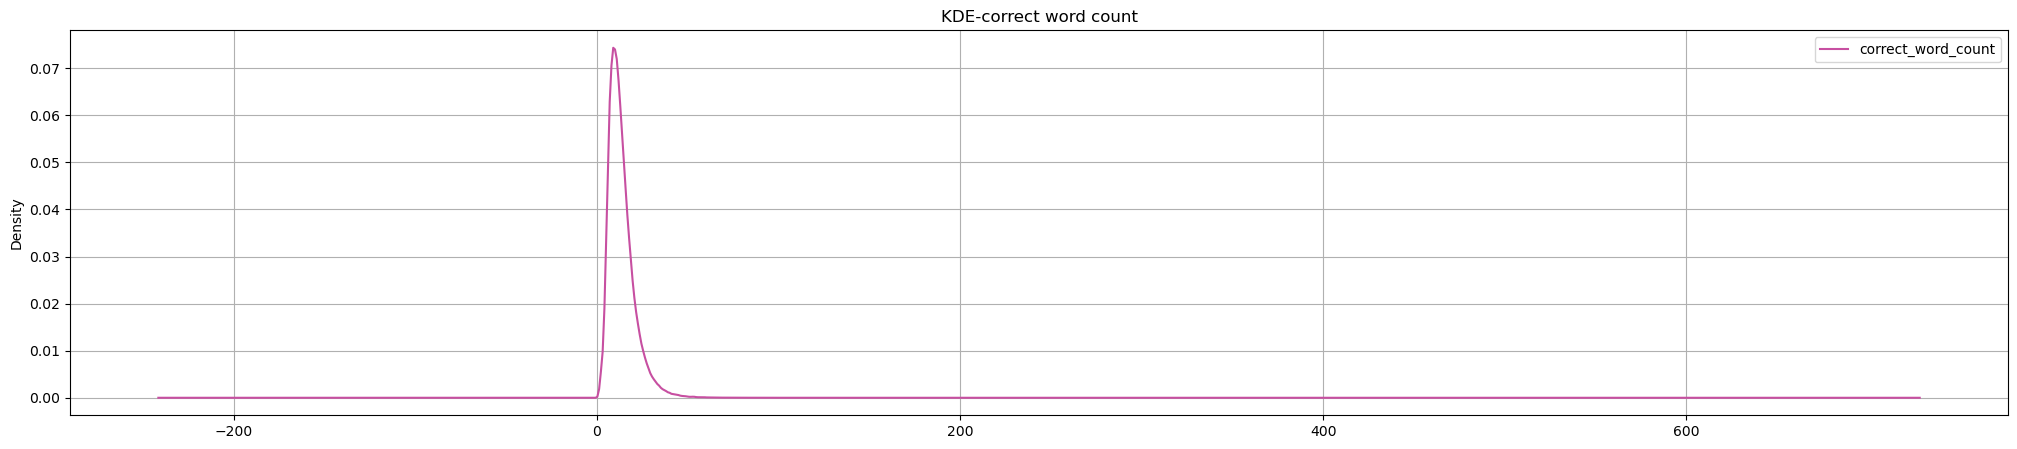

In [45]:
plot_univariate(final_df,'correct_word_count')

In [46]:
final_df['correct_word_count'].describe()

count    496287.000000
mean         13.602313
std           7.388188
min           1.000000
25%           9.000000
50%          12.000000
75%          17.000000
max         486.000000
Name: correct_word_count, dtype: float64

In [47]:
show_percentiles(final_df,'correct_word_count',(0,101),5)

,0,5,10,15,20,25,30,35,40,45,...,55,60,65,70,75,80,85,90,95,100
correct_word_count,1.0,5.0,6.0,7.0,8.0,9.0,9.0,10.0,11.0,11.0,...,13.0,14.0,15.0,16.0,17.0,18.0,20.0,23.0,27.0,486.0


In [48]:
show_percentiles(final_df,'correct_word_count',(90,101),1)

,90,91,92,93,94,95,96,97,98,99,100
correct_word_count,23.0,23.0,24.0,25.0,26.0,27.0,29.0,31.0,33.0,38.0,486.0


In [49]:
show_percentiles(final_df,'correct_word_count',(99.1,100),0.1)

,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100.0
correct_word_count,39.0,40.0,41.0,43.0,44.0,46.0,48.0,53.0,59.0,486.0


In [50]:
show_percentiles(final_df,'correct_word_count',(99.9,100),0.01)

,99.90,99.91,99.92,99.93,99.94,99.95,99.96,99.97,99.98,99.99
correct_word_count,59.0,61.0,62.0,63.0,65.2284,68.0,72.0,76.0,82.0,93.0


#### Inorrect Sentences

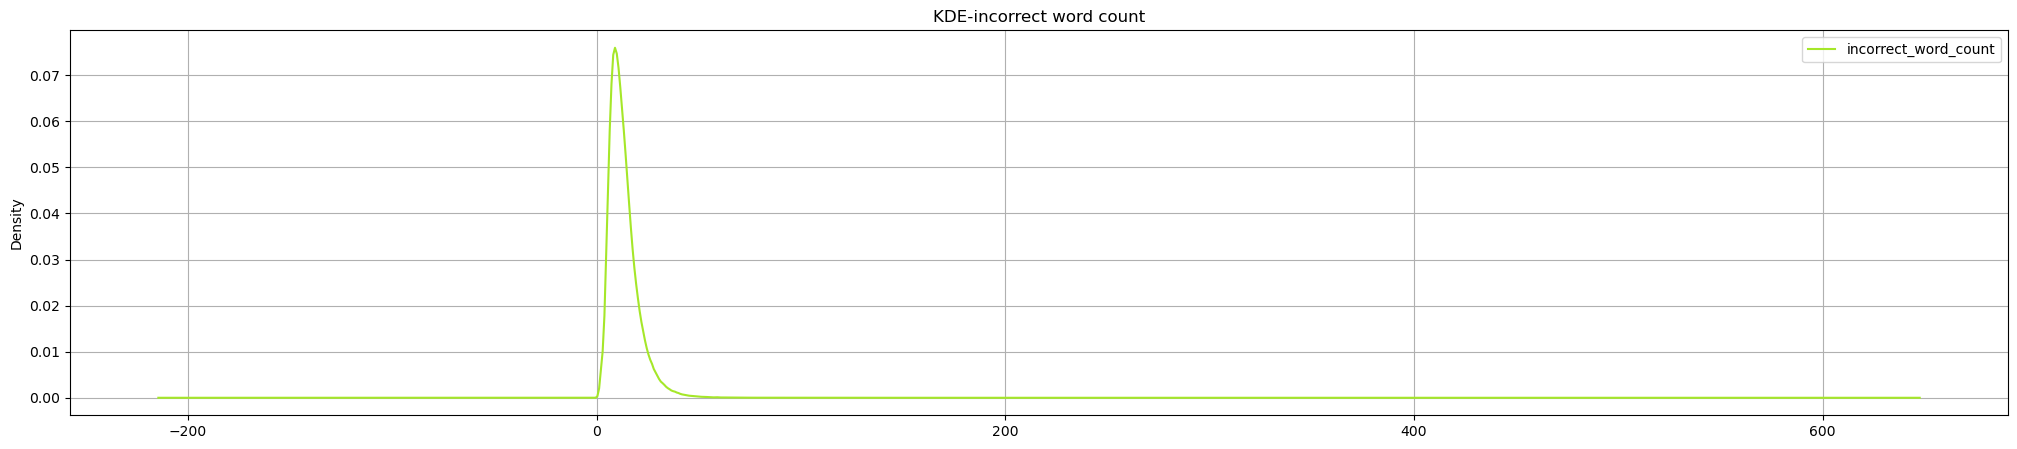

In [51]:
plot_univariate(final_df,'incorrect_word_count')

In [52]:
final_df['incorrect_word_count'].describe()

count    496287.000000
mean         13.229962
std           7.313167
min           1.000000
25%           8.000000
50%          12.000000
75%          16.000000
max         432.000000
Name: incorrect_word_count, dtype: float64

In [53]:
show_percentiles(final_df,'incorrect_word_count',(0,101),5)

,0,5,10,15,20,25,30,35,40,45,...,55,60,65,70,75,80,85,90,95,100
incorrect_word_count,1.0,5.0,6.0,7.0,8.0,8.0,9.0,10.0,10.0,11.0,...,12.0,13.0,14.0,15.0,16.0,18.0,20.0,22.0,27.0,432.0


In [54]:
show_percentiles(final_df,'incorrect_word_count',(90,101),1)

,90,91,92,93,94,95,96,97,98,99,100
incorrect_word_count,22.0,23.0,24.0,25.0,26.0,27.0,28.0,30.0,33.0,38.0,432.0


In [55]:
show_percentiles(final_df,'incorrect_word_count',(99.1,100),0.1)

,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100.0
incorrect_word_count,39.0,40.0,41.0,42.0,43.0,45.0,48.0,52.0,59.0,432.0


In [56]:
show_percentiles(final_df,'incorrect_word_count',(99.9,100),0.01)

,99.90,99.91,99.92,99.93,99.94,99.95,99.96,99.97,99.98,99.99
incorrect_word_count,59.0,60.0,62.0,63.0,65.0,68.0,71.0,75.0,79.7428,94.0


### Observations

1.   The character distriution for correct and incorrect senrtences shows mostly character lenth is between 50 to 80.
2.  The word count distribution tells most sentences are having 12 to 37 words.
3.  The distributions are  heavily skewed and there are extreme outliers present. 






## Bivariate Analysis(Scatter Plots)

In [57]:
def plot_scatter(df,feat_1,feat_2,title):
    fig,axs = plt.subplots(figsize=(10,10))
    x = sorted(list(df[feat_1]))
    y = sorted(list(df[feat_2]))
    random_color = (random.random(), random.random(), random.random())

    axs.scatter(x,y,marker=".",label=feat_1,color=random_color)
    line = mlines.Line2D([0, 1], [0, 1], color='black',linestyle=':',label='Normal Line')
    transform = axs.transAxes
    line.set_transform(transform)
    axs.add_line(line)
    axs.set_ylabel(feat_2)
    axs.grid()
    axs.set_xlabel(feat_1)
    axs.annotate(f"Correlation Score:{round((np.corrcoef(x,y)[0][1]),4)}", xy=(0.7, 0.5), xycoords='axes fraction',
            bbox=dict(boxstyle="round", fc="none", ec="gray"),
            xytext=(10, -40), textcoords='offset points', ha='center', fontsize=16)
    if title:
        plt.title(title)
    plt.show()

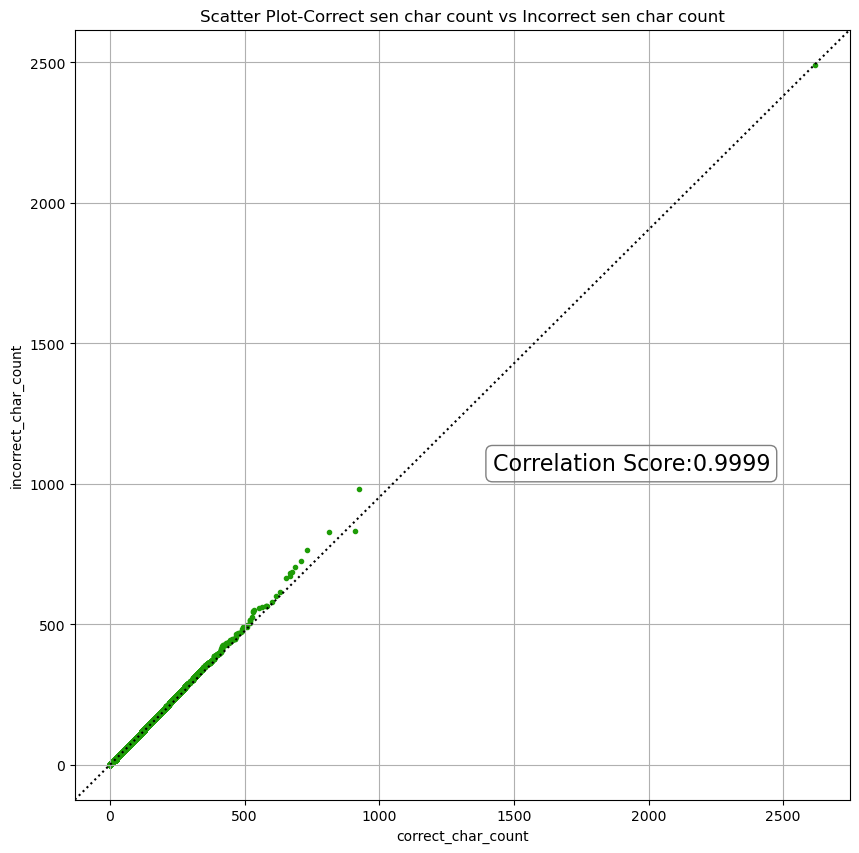

In [58]:
plot_scatter(final_df,'correct_char_count','incorrect_char_count',title='Scatter Plot-Correct sen char count vs Incorrect sen char count')

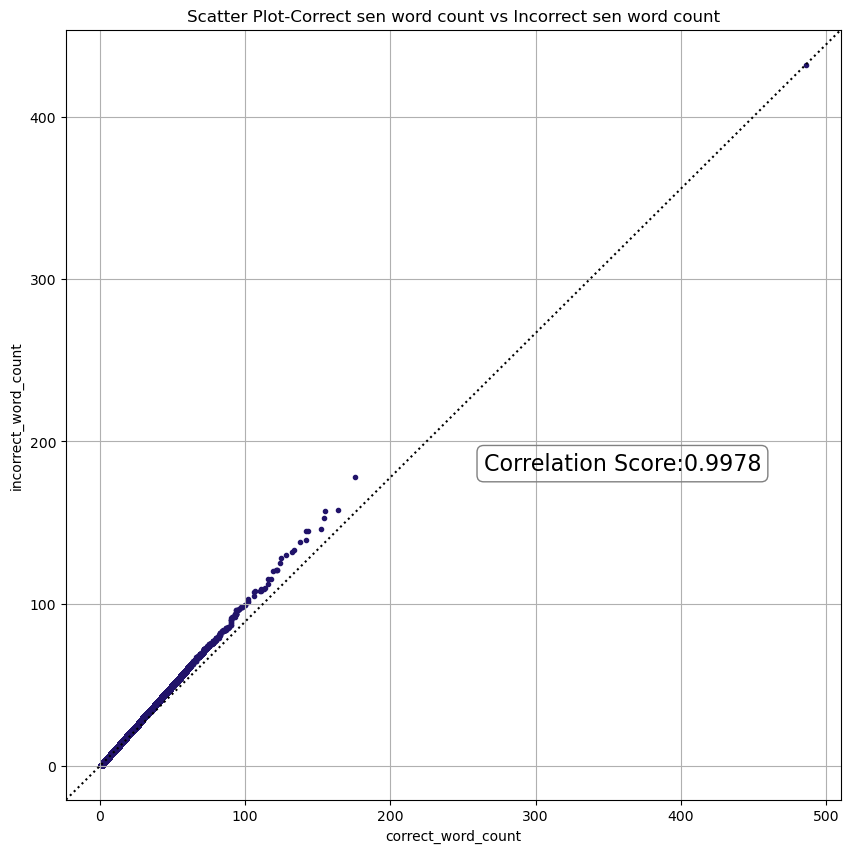

In [59]:
plot_scatter(final_df,'correct_word_count','incorrect_word_count','Scatter Plot-Correct sen word count vs Incorrect sen word count')

### Observations

1.   The character lenths and word counts for correct and incorrect sentences shows a very linear correlation with each other which tells distributions for correct and incorrect senteces are closely similar to each other.
3. Prima facie, we can state that there are not heavy edits made while correcting the sentence. 






## Stopword Analysis

In [60]:
stop=set(stopwords.words('english'))

In [61]:
#https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

def plot_top_stopwords(text,n_top=10,title=None):
    new= text.str.split()
    new= new.values.tolist()
    corpus=[word for i in new for word in i]

    stopword_dict=defaultdict(int)
    for word in corpus:
        if word in stop:
            stopword_dict[word]+=1

    df = pd.DataFrame()
    df['word'] = stopword_dict.keys()
    df['frequency'] = stopword_dict.values()
    df['percentage'] = df['frequency']*100/df['frequency'].sum()
    df = df.sort_values('frequency',ascending=False)
    df = df.iloc[:n_top]
    fig, ax = plt.subplots(figsize=(25,n_top/2))
    ax = sns.barplot(x = "frequency", y = "word",data=df, palette="nipy_spectral_r",orient='h')
    for i,p in enumerate(ax.patches):
        width = p.get_width()    # get bar length
        ax.text(width + 1,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                ' {:1.0f}'.format(width)+' ('+str(round(df['percentage'].iloc[i],2))+'%)', # set variable to display, 2 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment
    ax.set_xlim(xmin=0.0, xmax=round(max(df['frequency']),-4)*1.1)
    if title:
        plt.title(title)
    plt.show()

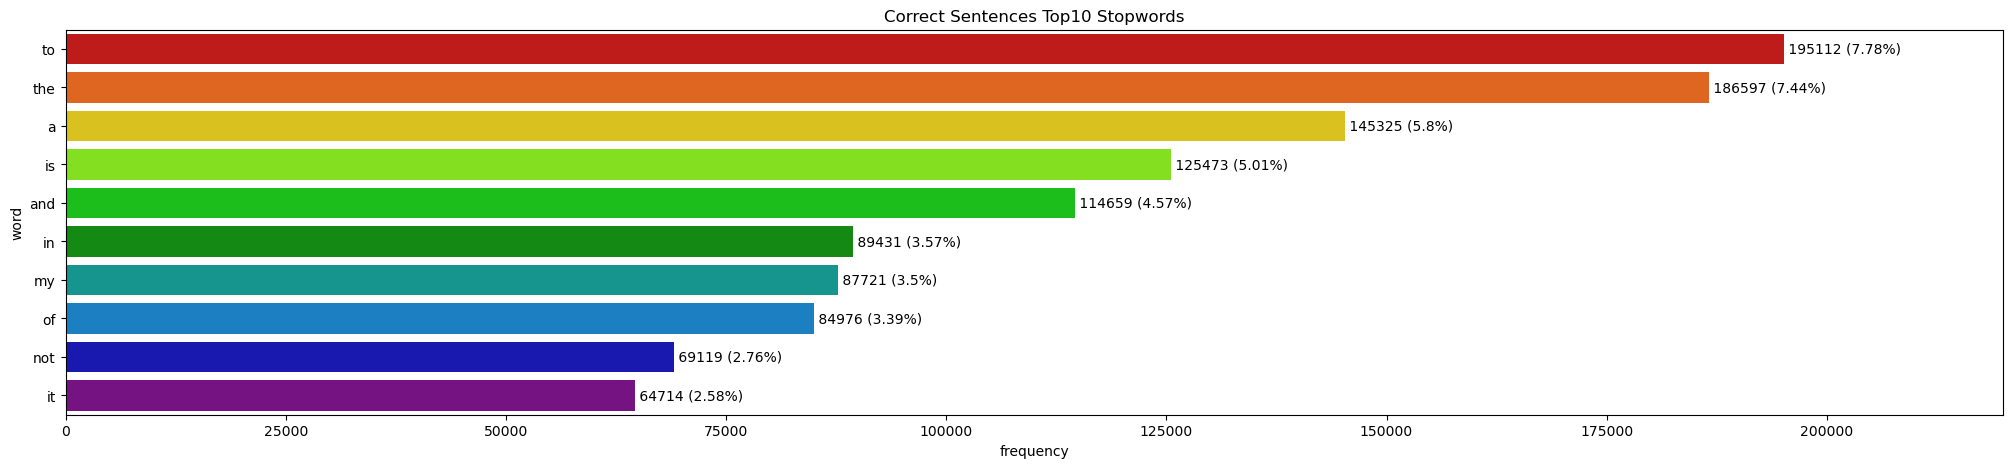

In [80]:
plot_top_stopwords(final_df['correct'].astype(str),title='Correct Sentences Top10 Stopwords')

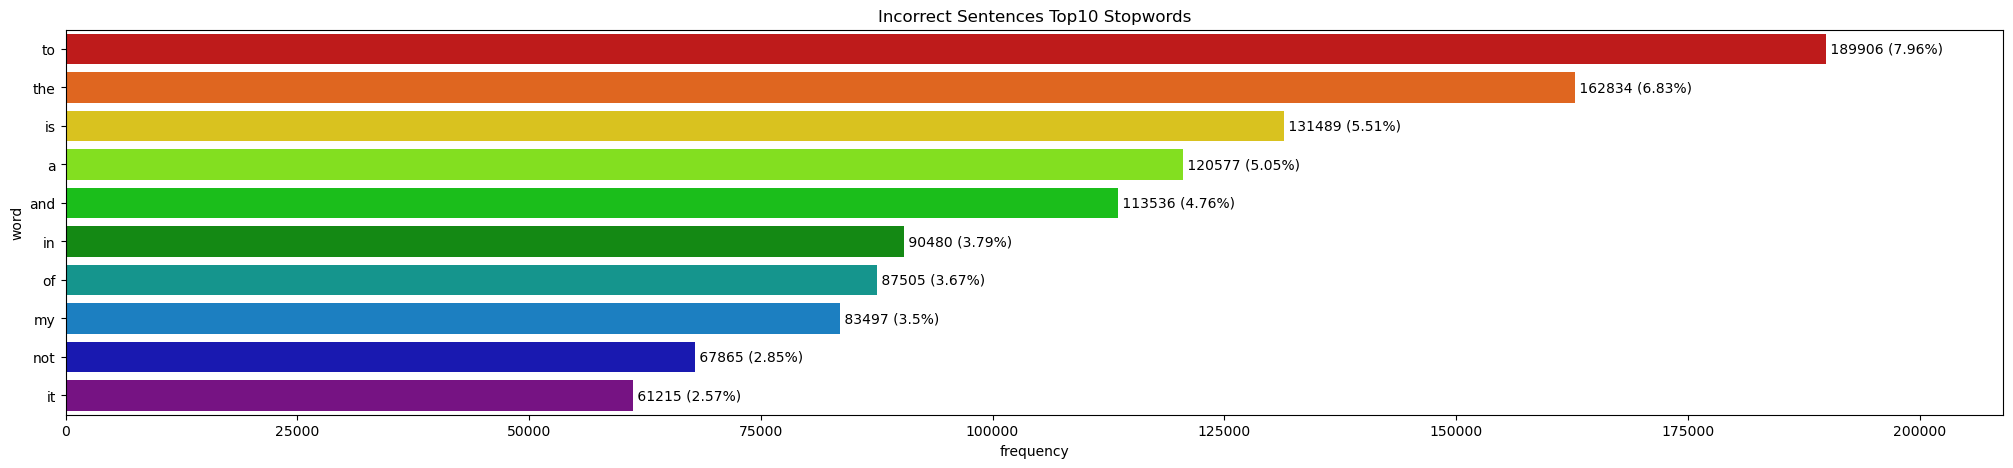

In [63]:
plot_top_stopwords(final_df['incorrect'].astype(str),title='Incorrect Sentences Top10 Stopwords')

### Observations

1.   Around 46% of stopwords are 'to','the','is','a','and','in','of','my','not' and 'it' where the distribution lies from 2.57% to 7.96%


## Ngram Analysis

In [81]:
def get_ngram_freq(text,n=2):
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    vec = CountVectorizer(ngram_range=(n, n)).fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return words_freq

In [82]:
def plot_top_ngrams(words_freq,n_top=10,title=None):
    df = pd.DataFrame()
    df['gram'] = [i[0] for i in words_freq]
    df['frequency'] = [i[1] for i in words_freq]
    df['percentage'] = df['frequency']*100/df['frequency'].sum()
    df = df.sort_values('frequency',ascending=False)
    df = df.iloc[:n_top]
    fig, ax = plt.subplots(figsize=(25,n_top/2))
    ax = sns.barplot(x = "frequency", y = "gram",data=df, palette="nipy_spectral_r",orient='h')
    for i,p in enumerate(ax.patches):
        width = p.get_width()    # get bar length
        ax.text(width + 1,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                ' {:1.0f}'.format(width)+' ('+str(round(df['percentage'].iloc[i],2))+'%)', # set variable to display, 2 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment
    ax.set_xlim(xmin=0.0, xmax=round(max(df['frequency']),-4)*1.1)
    if title:
        plt.title(title)
    plt.show()

In [84]:
correct_bigrams = get_ngram_freq(final_df['correct'].astype(str))

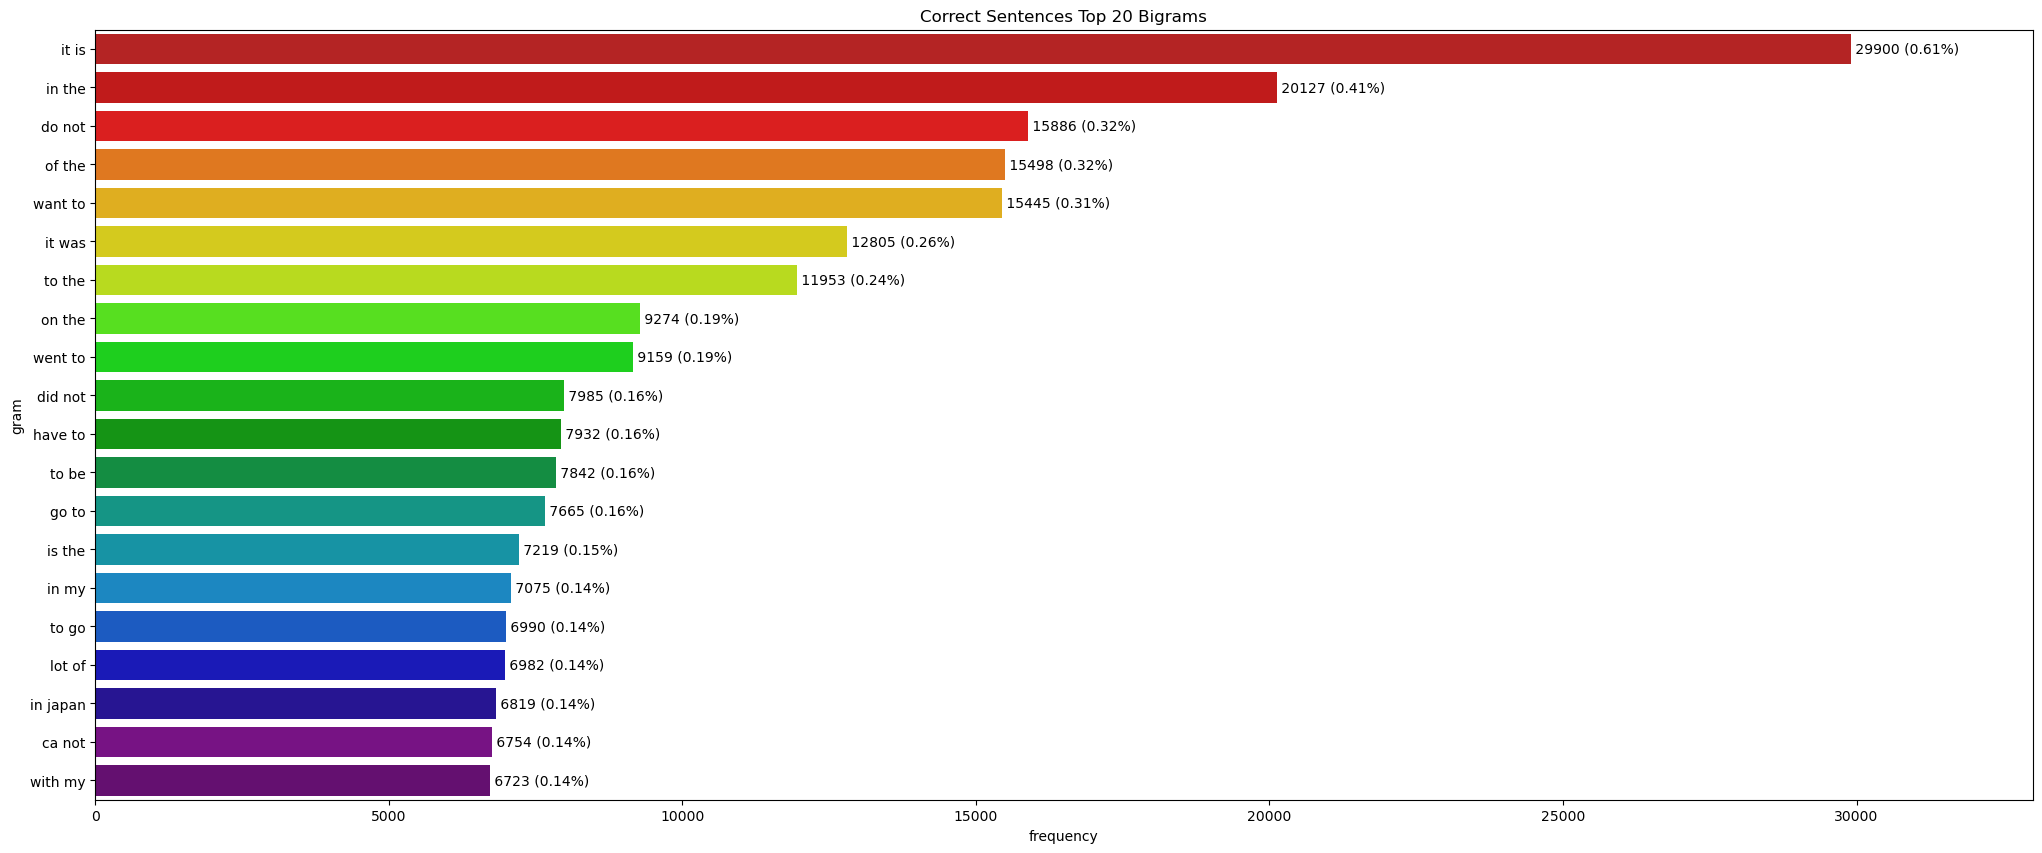

In [85]:
plot_top_ngrams(correct_bigrams,20,title='Correct Sentences Top 20 Bigrams')

In [86]:
incorrect_bigrams = get_ngram_freq(final_df['incorrect'].astype(str))

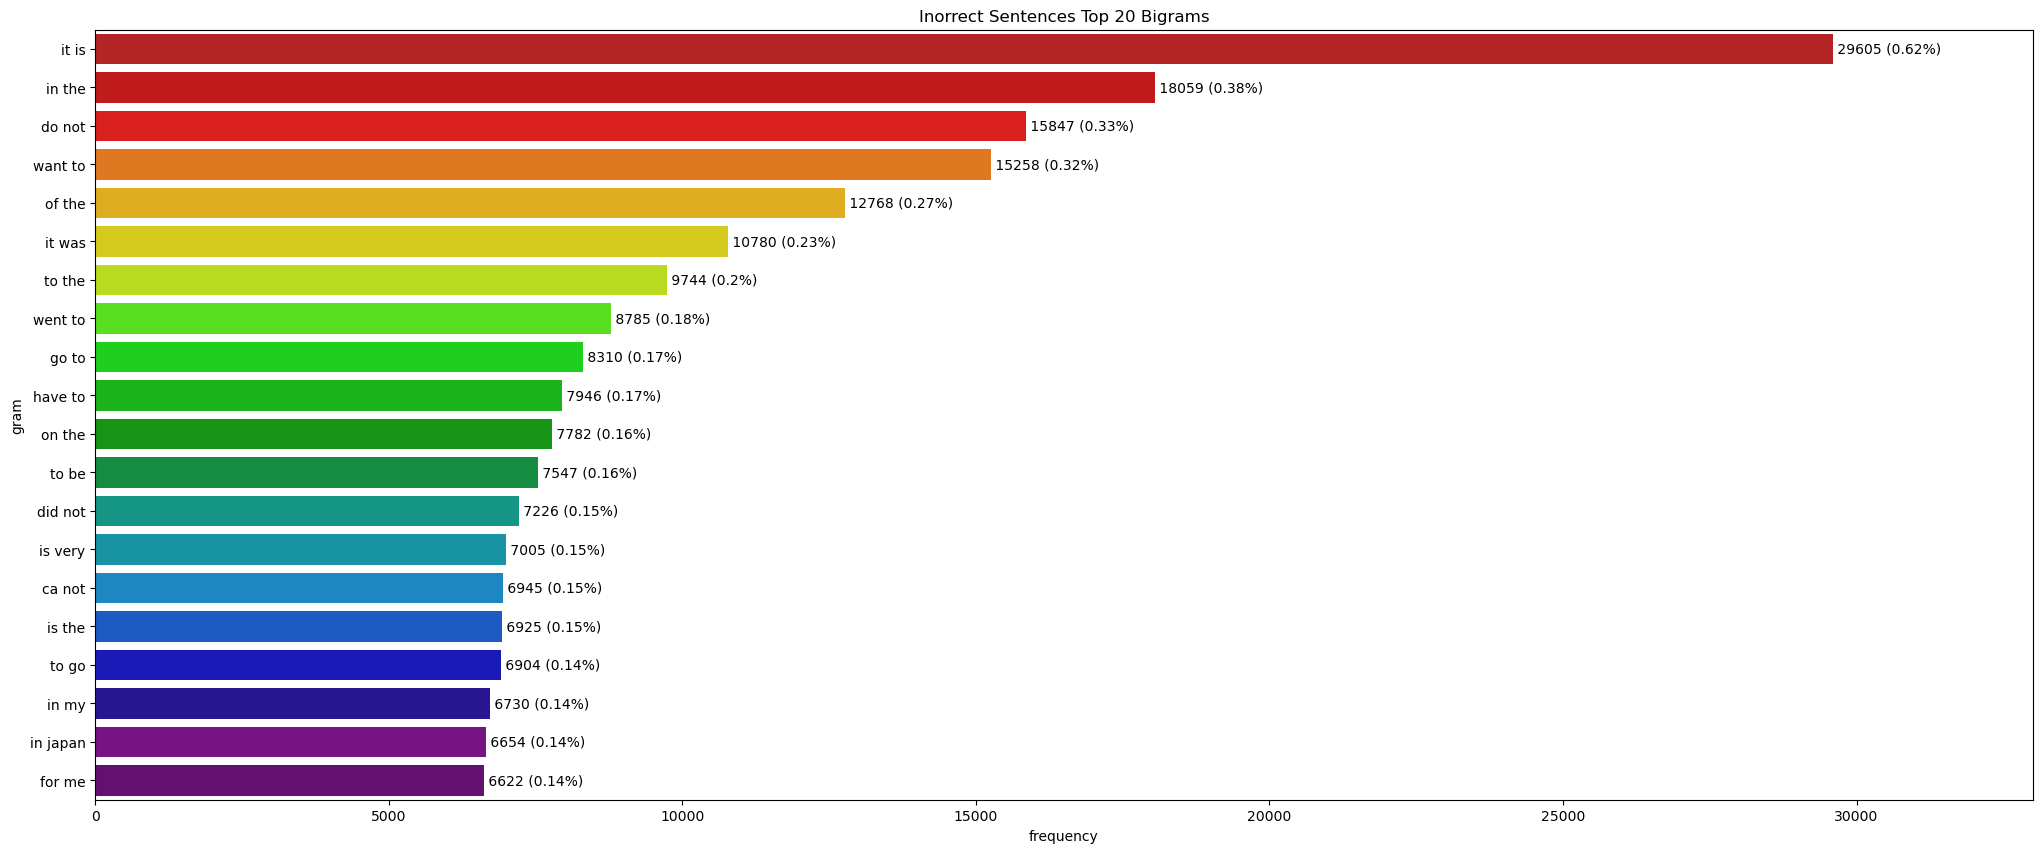

In [87]:
plot_top_ngrams(incorrect_bigrams,20,title='Inorrect Sentences Top 20 Bigrams')

## Wordcloud

In [88]:
def generate_wordcloud(text):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in tqdm(text):
        words=[w for w in word_tokenize(news) if (w not in stop)]

        words=[lem.lemmatize(w) for w in words if len(w)>2]

        corpus.append(words)
    return corpus

In [89]:
def plot_wordcloud(corpus,title=None):
    wordcloud = WordCloud(background_color='white',stopwords=set(STOPWORDS),
                          max_words=100,max_font_size=30,scale=3,random_state=1)
    wordcloud=wordcloud.generate(str(corpus))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    if title:
        plt.title(title)
    plt.show()

In [91]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\youse\AppData\Roaming\nltk_data...


True

In [93]:
correct_sen_wordcloud = generate_wordcloud(final_df['correct'].astype(str))

100%|██████████| 496287/496287 [00:53<00:00, 9288.58it/s]


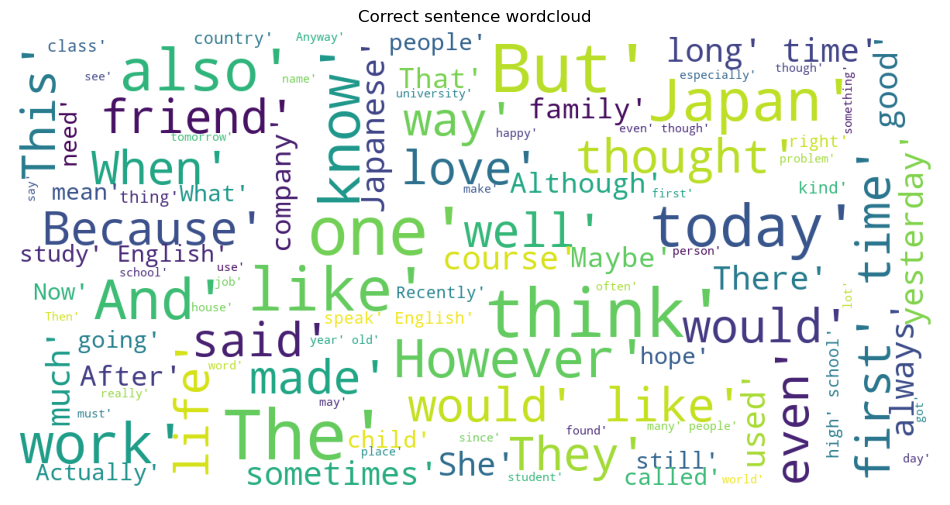

In [94]:
plot_wordcloud(correct_sen_wordcloud,'Correct sentence wordcloud')

In [95]:
incorrect_sen_corpus = generate_wordcloud(final_df['incorrect'].astype(str))

100%|██████████| 496287/496287 [00:51<00:00, 9621.43it/s] 


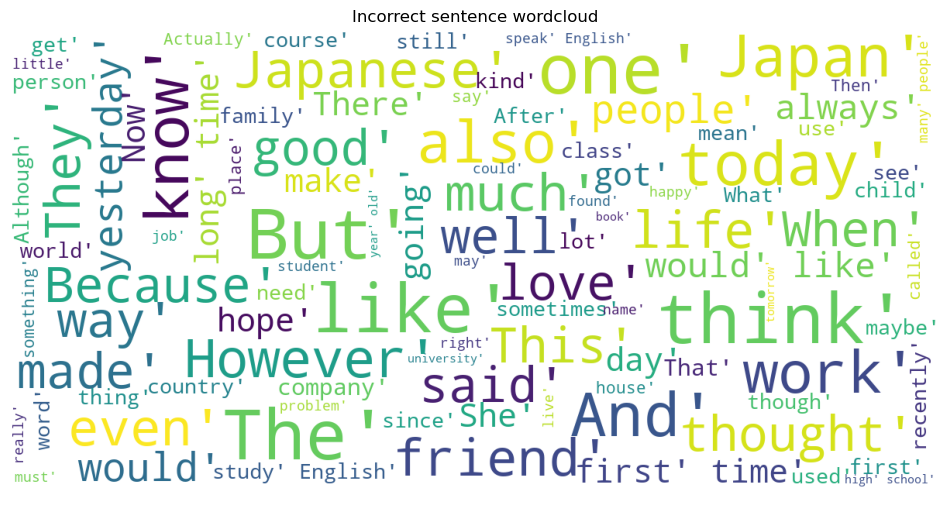

In [96]:
plot_wordcloud(incorrect_sen_corpus,'Incorrect sentence wordcloud')

### Observations


1. We can observe words like "But","Also","elderly","One","need","Japan" are frequently used in Correct & Incorrect Sentence



## Sentiment analysis

In [97]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [99]:
final_df['correct_sen_polarity_score'] = final_df['correct'].astype(str).apply(polarity)
final_df['incorrect_sen_polarity_score'] = final_df['incorrect'].astype(str).apply(polarity)

In [100]:
def sentiment(x):
    if x<0:
        return 'Negative'
    elif x==0:
        return 'Neutral'
    else:
        return 'Positive'

In [101]:
final_df['correct_sen_polarity'] = final_df['correct_sen_polarity_score'].apply(sentiment)
final_df['incorrect_sen_polarity'] = final_df['incorrect_sen_polarity_score'].apply(sentiment)

In [102]:
def plot_polarity(polarity,title=None):
    fig,ax = plt.subplots(figsize =(10, 7))
    labels_Class_Disb = polarity.value_counts().index
    sizes_Class_Disb = polarity.value_counts()
    pcts_Class_Disb = [f'{l}-{s} Points \n({s*100/sum(sizes_Class_Disb):.2f}%)' for s,l in zip(sizes_Class_Disb, labels_Class_Disb)] 
    ax.pie(sizes_Class_Disb, labels = pcts_Class_Disb,startangle = 90, 
        explode=(0.05,0.05,0.05),colors = ('gray','#2a9d8f','#e76f51',), textprops = {"fontsize":12} )
    if title:
        plt.suptitle(title ,fontsize = 15)
    plt.title(f'(No Of Data Points:{sum(sizes_Class_Disb)}) ', fontsize = 12)
    plt.show()

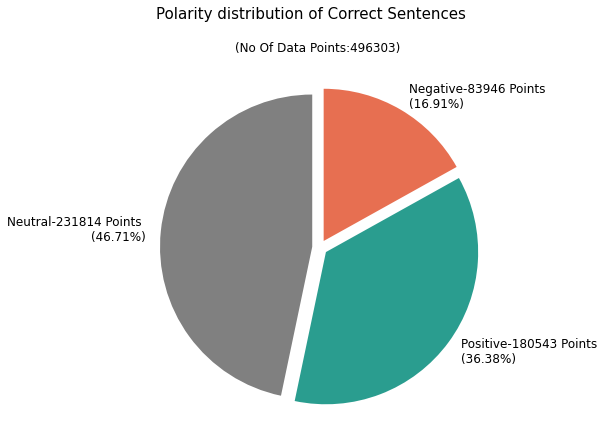

In [71]:
plot_polarity(final_df['correct_sen_polarity'],'Polarity distribution of Correct Sentences')

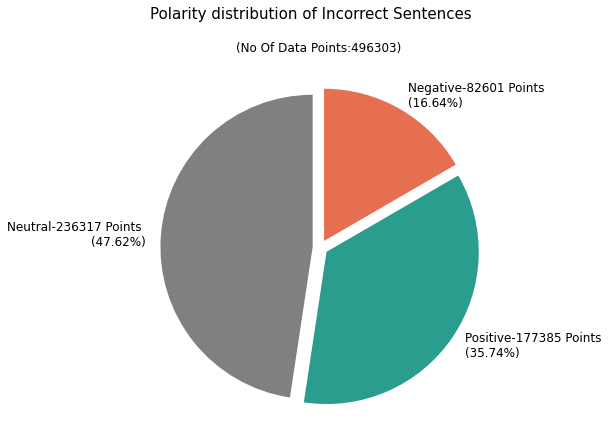

In [72]:
plot_polarity(final_df['incorrect_sen_polarity'],'Polarity distribution of Incorrect Sentences')

## Text complexity using Flesch Reading Ease (FRE)
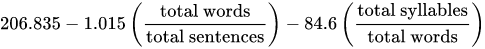

Higher scores indicate material that is easier to read,
lower numbers mark harder-to-read passages:


<table class="wikitable" border="1">

<tbody><tr>
<th>Score
</th>
<th>School level (<a href="/wiki/Education_in_the_United_States" title="Education in the United States">US</a>)
</th>
<th>Notes
</th></tr>
<tr>
<td>100.00–90.00
</td>
<td>5th grade
</td>
<td>Very easy to read. Easily understood by an average 11-year-old student.
</td></tr>
<tr>
<td>90.0–80.0
</td>
<td>6th grade
</td>
<td>Easy to read. Conversational English for consumers.
</td></tr>
<tr>
<td>80.0–70.0
</td>
<td>7th grade
</td>
<td>Fairly easy to read.
</td></tr>
<tr>
<td>70.0–60.0
</td>
<td>8th &amp; 9th grade
</td>
<td>Plain English. Easily understood by 13- to 15-year-old students.
</td></tr>
<tr>
<td>60.0–50.0
</td>
<td>10th to 12th grade
</td>
<td>Fairly difficult to read.
</td></tr>
<tr>
<td>50.0–30.0
</td>
<td>College
</td>
<td>Difficult to read.
</td></tr>
<tr>
<td>30.0–10.0
</td>
<td>College graduate
</td>
<td>Very difficult to read. Best understood by university graduates.
</td></tr>
<tr>
<td>10.0–0.0
</td>
<td>Professional
</td>
<td>Extremely difficult to read. Best understood by university graduates.
</td></tr></tbody></table>

In [104]:
final_df['correct_sen_complexity_score'] = final_df['correct'].astype(str).progress_apply(flesch_reading_ease)

100%|██████████| 496287/496287 [00:15<00:00, 32501.04it/s]


In [105]:
final_df['incorrect_sen_complexity_score'] = final_df['incorrect'].astype(str).progress_apply(flesch_reading_ease)

100%|██████████| 496287/496287 [00:14<00:00, 34915.46it/s]


In [106]:
#https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
def complexity(x):
    if x<10:
        return 'Professional'
    elif x>10 and x<=30:
        return 'College graduate(Very Difficult)'
    elif x>30 and x<=50:
        return 'College (Difficult)'
    elif x>50 and x<=60:
        return '10th to 12th grade(Fairly difficult)'
    elif x>60 and x<=70:
        return '8th & 9th grade(Plain English)'
    elif x>70 and x<=80:
        return '7th grade(Fairly easy)'
    elif x>80 and x<=90:
        return '6th grade(Easy to read)'
    elif x>90:
        return '5th grade(Very easy)'

In [107]:
final_df['correct_sen_complexity'] = final_df['correct_sen_complexity_score'].progress_apply(complexity)

100%|██████████| 496287/496287 [00:00<00:00, 1145923.77it/s]


In [108]:
final_df['incorrect_sen_complexity'] = final_df['incorrect_sen_complexity_score'].progress_apply(complexity)

100%|██████████| 496287/496287 [00:00<00:00, 1154188.27it/s]


In [109]:
def plot_complexity(df,feature,title=None):
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw=dict(aspect="equal"))

    disb_dict = dict(df[feature].value_counts())
    data = disb_dict.values()
    data_labels = list(disb_dict.keys())

    #https://www.pythonprogramming.in/how-to-pie-chart-with-different-color-themes-in-matplotlib.html
    cmap_list = list(mpl.cm.cmap_d.keys())
    cmap = random.choice(cmap_list)
    theme = plt.get_cmap('RdBu')
    ax.set_prop_cycle("color", [theme(1. * i / len(data))
                                for i in range(len(data))])

    #https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    wedges, texts = ax.pie(data, wedgeprops=dict(width=0.2), startangle=-40)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        pcts_Class_Disb = [f'{l}-{s} Points ({s*100/sum(data):.2f}%)' for s,l in zip(data, data_labels)] 
        ax.annotate(pcts_Class_Disb[i], xy=(x, y), xytext=(1.25*np.sign(x), 1.7*y),
                    horizontalalignment=horizontalalignment, **kw)
    
    plt.title(f'(No Of Data Points:{sum(data)})',fontsize = 12)
    if title:
        plt.suptitle(title,fontsize = 16)
    plt.show()

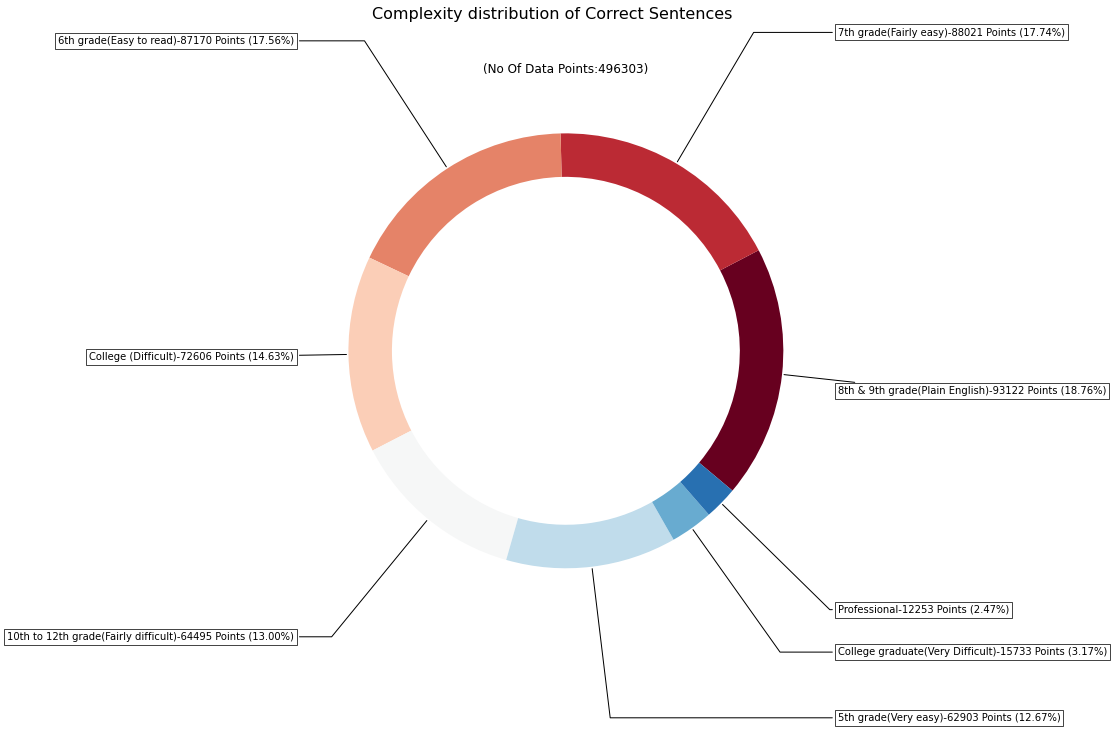

In [73]:
plot_complexity(final_df,'correct_sen_complexity',title='Complexity distribution of Correct Sentences' )

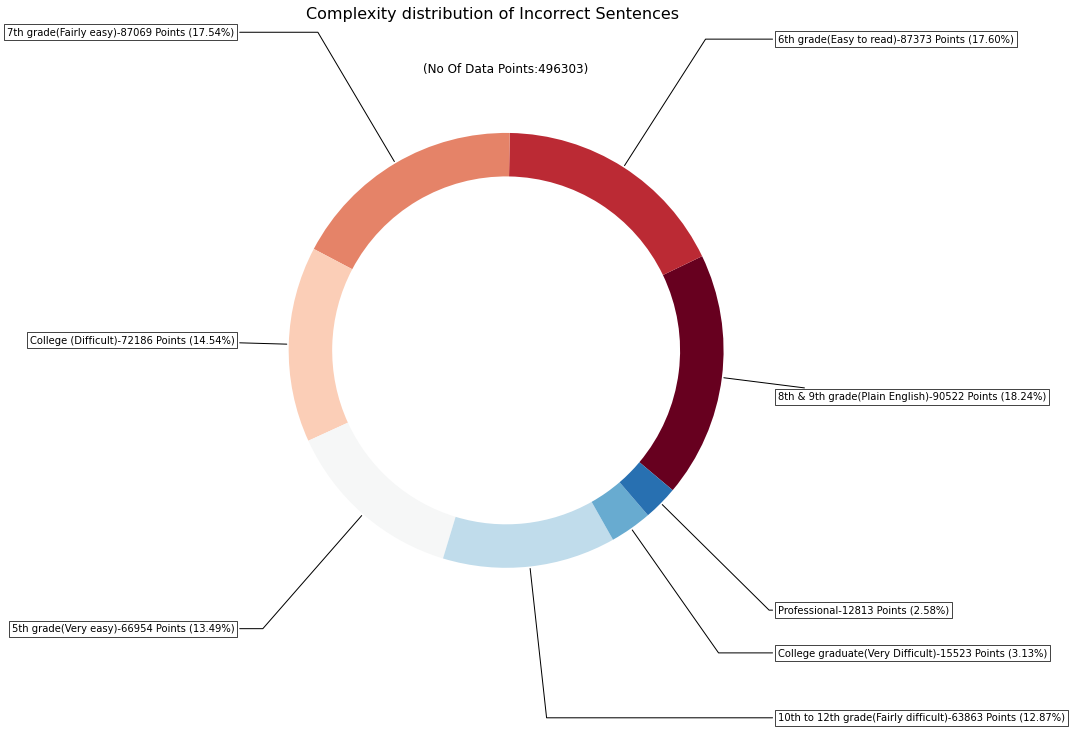

In [74]:
plot_complexity(final_df,'incorrect_sen_complexity',title='Complexity distribution of Incorrect Sentences' )

### Observations

1.   Around 67 % of the text is categorized as suitable for above 5th grade or  FRE score above 



In [110]:
final_df.to_csv('final_with_feat_20211105.csv')

## Train Test Split

In [111]:
from sklearn.model_selection import train_test_split

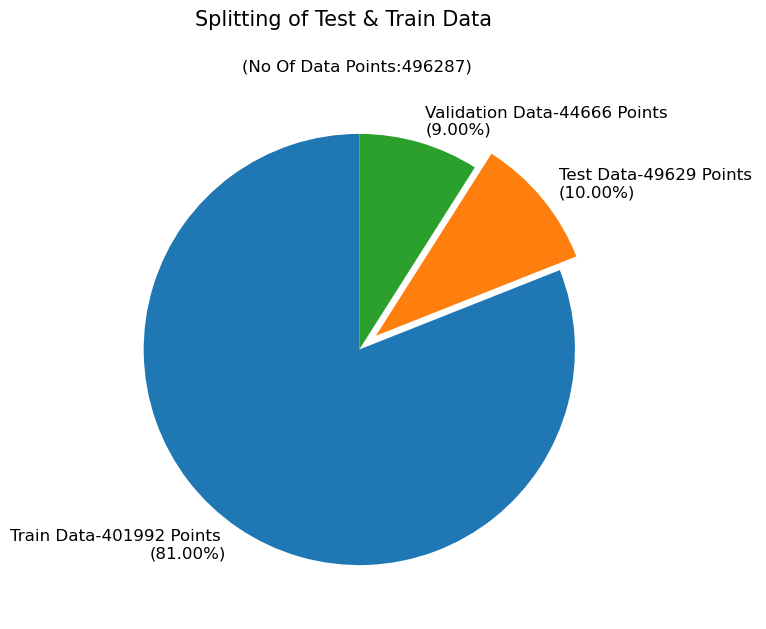

In [112]:
train,test = train_test_split(final_df, test_size=0.1)
train,validation = train_test_split(train, test_size=0.1)
fig,ax = plt.subplots(figsize =(10, 7))
labels_split = ['Train', 'Test','Validation'] 
sizes_split = [len(train),len(test),len(validation)]
pcts_split = [f'{l} Data-{s} Points \n({s*100/sum(sizes_split):.2f}%)' for s,l in zip(sizes_split, labels_split)] 
ax.pie(sizes_split, labels = pcts_split, startangle = 90, 
       explode=(0,0.1,0),textprops = {"fontsize":12} )

plt.suptitle(f'Splitting of Test & Train Data ', fontsize = 15)
plt.title(f'(No Of Data Points:{sum(sizes_split)}) ', fontsize = 12)
plt.show()

In [114]:
train.to_csv('train_20211105')
validation.to_csv('validation_20211105')
test.to_csv('test_20211105')